In [1]:
import os, sys
import esutil
import healpy as hp
import numpy as np
import fitsio
%matplotlib inline

%load_ext autoreload
%autoreload 2

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
sys.path.append('../')
from xd import *
from run_DMASS_Y3 import *
from utils import *
import healpy as hp
from systematics import *
from cmass_modules import io

In [3]:
os.chdir('../../DMASS_XDGMM/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASS_XDGMM/code_py3


In [4]:
from xdgmm import XDGMM as XDGMM_Holoien

In [5]:
def _FindOptimalN_with_err( N, Xdata, Xcov, pickleFileName = None, suffix = None):
    #from sklearn.mixture import GMM
    #data, _ = mixing_color(data, suffix = suffix)
    @pickle_results( pickleFileName )
    def compute_GMM( N, covariance_type='full', n_iter=1000):
        models = [None for n in N]
        for i in range(len(N)):
            sys.stdout.write("\r" + 'Finding optimal number of cluster : {:0.0f} % '\
                             .format(i * 1./len(N) * 100.))
            sys.stdout.flush()
            models[i] = GaussianMixture(n_components=N[i], max_iter=n_iter,
                            covariance_type=covariance_type)
            models[i].fit(Xdata, Xcov)
        return models
    
    models = compute_GMM(N)
    AIC = [m.aic(Xdata) for m in models]
    BIC = [m.bic(Xdata) for m in models]
    i_best = np.argmin(BIC)
    gmm_best = models[i_best]
    sys.stdout.write("\r" + 'Finding optimal number of cluster : {:0.0f} % '\
                     .format(100))
    print("\nbest fit converged:", gmm_best.converged_, end=' ')
    print(" n_components =  %i" % N[i_best])
    return N[i_best], AIC, BIC

def XDnew_fitting_X( X = None, Xcov=None, 
        FileName = None, 
        #init_params = None, 
        #suffix='', 
        #mag = ['MAG_MODEL', 'MAG_DETMODEL'],
        #err = [ 'MAGERR_MODEL','MAGERR_DETMODEL'],
        #filter = ['G', 'R', 'I'],
        n_cl = None, n_iter = 500, tol=1E-5, method='Bovy', verbose=False ):

    

    try: 
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        print ('Using precomputed results from ', FileName)
        return xdgmm_obj
    except FileNotFoundError: pass
    
    if X is None:
        # calling pre-computed model
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        print ('Using precomputed results from ', FileName)
        return xdgmm_obj

    else: 
        if n_cl == None : 
            param_range=np.arange(2, 50, 2)
            optimal_n_comp,_,_= _FindOptimalN_with_err( param_range, X, Xcov, 
            pickleFileName = FileName+'.n_cluster' , suffix = '')
            
            #xdgmm_test = XDGMM_Holoien( n_iter=n_iter, tol=tol, method=method )
            ## Define the range of component numbers, and get ready to compute the BIC for each one:
            #param_range = np.arange(2, 50, 2)
            ## Loop over component numbers, fitting XDGMM model and computing the BIC:
            #bic, optimal_n_comp, lowest_bic = xdgmm_test.bic_test(X, Xcov, param_range)
            ##n_cl = optimal_n_comp[np.argmin(bic)]
        else: optimal_n_comp = n_cl

        #import time
        # fitting
        #initiated class
        xdgmm_obj = XDGMM_Holoien( n_components=optimal_n_comp, n_iter=n_iter, tol=tol, method=method )
        #xdgmm.n_components = optimal_n_comp
        print ('n_components=', optimal_n_comp)
        print ('fitting started. This will take for a while.')
#        t1 = time.time()
        xdgmm_obj = xdgmm_obj.fit(X, Xcov)
        #t2 = time.time()
        print ('fitting finished')
        
        #t3 = time.time()
        print ('saving xdgmm object to.. ', FileName)
        xdgmm_obj.save_model(FileName)
        print ('file saved')
        #print ('saving obj. time:', (t3-t2)%60,'s')
        
        #t4 = time.time()
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        #print ('loading obj. time:', (t4-t3)%60,'s')
#        t2 = time.time()
#        print ('elapsed time:', (t2-t1)/60.0,'s')
        return xdgmm_obj

In [6]:
os.chdir('../../DMASSY3/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASSY3/code_py3


In [7]:
#load in:
clf_dmass = XDGMM_Holoien(filename='output/test/fitting/gauss_gold_bovyY3_130DETfixed.xdgmm')
clf_nodmass = XDGMM_Holoien(filename='output/test/fitting/gauss_nogold_bovyY3_130DETfixed.xdgmm')

In [8]:
# call required functions from modules 

sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test

# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
#input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/'
input_path = '/fs/scratch/PCON0003/warner785/bwarner/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
input_keyword = 'Y3_GOLD_2_0_STRIPE82'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z', 'EXTENDED_CLASS_MASH_SOF', 'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 
            'MAGERR_DETMODEL_G', 'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z',
            'MOF_CM_MAG_CORRECTED_G', 'MOF_CM_MAG_CORRECTED_R', 'MOF_CM_MAG_CORRECTED_I', 'MOF_CM_MAG_CORRECTED_Z',
            'MOF_CM_MAG_ERR_G', 'MOF_CM_MAG_ERR_R', 'MOF_CM_MAG_ERR_I', 'MOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]
gold_st82 = gold_st82[(gold_st82['EXTENDED_CLASS_MASH_SOF'] == 3)]

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

print(gold_st82.size)    
gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)


Calling catalogs >>>
Y3_GOLD_2_0_STRIPE82_000125.fits
Y3_GOLD_2_0_STRIPE82_000136.fits
Y3_GOLD_2_0_STRIPE82_000040.fits
Y3_GOLD_2_0_STRIPE82_000015.fits
Y3_GOLD_2_0_STRIPE82_000086.fits
Y3_GOLD_2_0_STRIPE82_000047.fits
Y3_GOLD_2_0_STRIPE82_000108.fits
Y3_GOLD_2_0_STRIPE82_000079.fits
Y3_GOLD_2_0_STRIPE82_000076.fits
Y3_GOLD_2_0_STRIPE82_000057.fits
Y3_GOLD_2_0_STRIPE82_000111.fits
Y3_GOLD_2_0_STRIPE82_000084.fits
Y3_GOLD_2_0_STRIPE82_000088.fits
Y3_GOLD_2_0_STRIPE82_000049.fits
Y3_GOLD_2_0_STRIPE82_000063.fits
Y3_GOLD_2_0_STRIPE82_000070.fits
Y3_GOLD_2_0_STRIPE82_000077.fits
Y3_GOLD_2_0_STRIPE82_000042.fits
Y3_GOLD_2_0_STRIPE82_000118.fits
Y3_GOLD_2_0_STRIPE82_000115.fits
Y3_GOLD_2_0_STRIPE82_000028.fits
Y3_GOLD_2_0_STRIPE82_000140.fits
Y3_GOLD_2_0_STRIPE82_000060.fits
Y3_GOLD_2_0_STRIPE82_000089.fits
Y3_GOLD_2_0_STRIPE82_000143.fits
Y3_GOLD_2_0_STRIPE82_000012.fits
Y3_GOLD_2_0_STRIPE82_000001.fits
Y3_GOLD_2_0_STRIPE82_000045.fits
Y3_GOLD_2_0_STRIPE82_000137.fits
Y3_GOLD_2_0_STRIPE82_

In [9]:
#this CMASS used for Y1, and Y3 now:

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 61031


In [10]:
mask = (gold_st82['RA']>310) & (gold_st82['RA']<360)
mask = mask & (gold_st82['DEC']>-2) & (gold_st82['DEC']<2)
gold_st82_train = gold_st82[mask]

print(gold_st82_train.size)

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_train['RA'], \
                                         gold_st82_train['DEC'],2./3600, maxmatch=1)
cmass_mask_train = np.zeros(gold_st82_train.size, dtype=bool)
cmass_mask_train[mg2] = 1
clean_cmass_data_des_train, nocmass_train = gold_st82_train[cmass_mask_train], gold_st82_train[~cmass_mask_train]

clean_cmass_data_des = clean_cmass_data_des_train

cmass_fraction_full = clean_cmass_data_des_train.size*1./gold_st82_train.size
print(cmass_fraction_full)

1192126
0.01106678320915742


calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00120325 0.09069189 0.14228476 0.19256757 0.2474413  0.29333333
 0.35555556 0.38879098 0.4405621  0.47532362 0.53876828 0.58169621
 0.63697917 0.68641846 0.74161939 0.78095238 0.84792627 0.86746362
 0.8747541  0.92145015]
chi2_reduced:  62746.53234005596
size:  20
sum of chi2:  1254930.6468011192


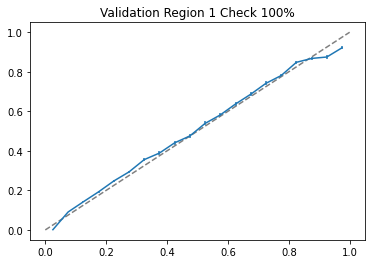

In [11]:
#(Validation 1) Figure 3

mag = ['MAG_DETMODEL', 'MAG_DETMODEL']
err = ['MAGERR_DETMODEL', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

mask1 = (gold_st82['RA']<30)
mask1 = mask1 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v1 = gold_st82[mask1]

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_v1['RA'], \
                                         gold_st82_v1['DEC'],2./3600, maxmatch=1)
cmass_mask1 = np.zeros(gold_st82_v1.size, dtype=bool)
cmass_mask1[mg2] = 1
clean_cmass_data_des_v1, nocmass_v1 = gold_st82_v1[cmass_mask1], gold_st82_v1[~cmass_mask1]

clean_dmass_prob1 = assignCMASSProb(clean_cmass_data_des_v1, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real1 = clean_dmass_prob1

dmass_st82_val1 = assignCMASSProb(gold_st82_v1, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real1['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val1['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
#fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
fracerr = (N/M)*np.sqrt((1/N)-(1/M))

x1=frac
x2=pcenter
err=fracerr
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')
#ax.legend(chi2_reduced)
plt.title('Validation Region 1 Check 100%')
fig.savefig('DET_Val1_100_err.pdf')

#describe plot: ***used for model and validation sample-- what is done to create plot

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00116646 0.08978608 0.14309623 0.19378163 0.25530876 0.29384183
 0.35942136 0.38758681 0.44609665 0.48025666 0.54225352 0.58018868
 0.63185042 0.69023136 0.73766234 0.7838731  0.85288523 0.85723473
 0.86672052 0.91060026]
chi2_reduced:  53532.45132881516
size:  20
sum of chi2:  1070649.0265763032


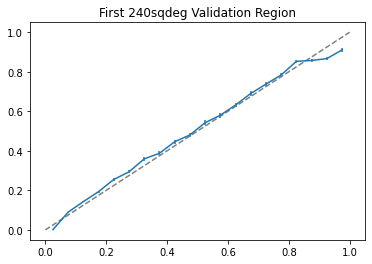

In [21]:
#new validation regions: 240sqdegs

#(new Validation 2) Figure 3

mag = ['MAG_DETMODEL', 'MAG_DETMODEL']
err = ['MAGERR_DETMODEL', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

mask2 = (gold_st82['RA']<26)
mask2 = mask2 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v2 = gold_st82[mask2]

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_v2['RA'], \
                                         gold_st82_v2['DEC'],2./3600, maxmatch=1)
cmass_mask2 = np.zeros(gold_st82_v2.size, dtype=bool)
cmass_mask2[mg2] = 1
clean_cmass_data_des_v2, nocmass_v2 = gold_st82_v2[cmass_mask2], gold_st82_v2[~cmass_mask2]

clean_dmass_prob2 = assignCMASSProb(clean_cmass_data_des_v2, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real2 = clean_dmass_prob2

dmass_st82_val2 = assignCMASSProb(gold_st82_v2, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real2['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val2['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
#fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
fracerr = (N/M)*np.sqrt((1/N)-(1/M))

x1=frac
x2=pcenter
err=fracerr
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')
#ax.legend(chi2_reduced)
plt.title('First 240sqdeg Validation Region')
fig.savefig('DET_240Val1_err.pdf')

#describe plot: ***used for model and validation sample-- what is done to create plot

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00120435 0.08674254 0.1407214  0.18217191 0.2293601  0.29315153
 0.33720495 0.393071   0.41685966 0.47982063 0.53661202 0.57046569
 0.62375622 0.66167859 0.7293883  0.77462121 0.84101233 0.86738579
 0.8922734  0.92118227]
chi2_reduced:  50249.311070951735
size:  20
sum of chi2:  1004986.2214190348


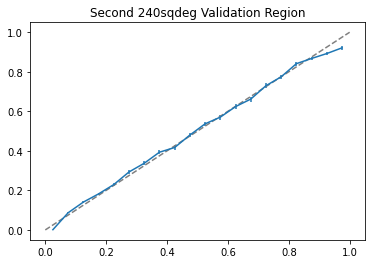

In [12]:
#(new Validation 3) Figure 3

mag = ['MAG_DETMODEL', 'MAG_DETMODEL']
err = ['MAGERR_DETMODEL', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

mask3 =(gold_st82['RA']>26)&(gold_st82['RA']<70)
mask3 = mask3 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v3 = gold_st82[mask3]

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_v3['RA'], \
                                         gold_st82_v3['DEC'],2./3600, maxmatch=1)
cmass_mask3 = np.zeros(gold_st82_v3.size, dtype=bool)
cmass_mask3[mg2] = 1
clean_cmass_data_des_v3, nocmass_v3 = gold_st82_v3[cmass_mask3], gold_st82_v3[~cmass_mask3]

clean_dmass_prob3 = assignCMASSProb(clean_cmass_data_des_v3, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real3 = clean_dmass_prob3

dmass_st82_val3 = assignCMASSProb(gold_st82_v3, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real3['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val3['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
#fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
fracerr = (N/M)*np.sqrt((1/N.astype(float))-(1/M.astype(float)))

x1=frac
x2=pcenter
err=fracerr
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')
#ax.legend(chi2_reduced)
plt.title('Second 240sqdeg Validation Region')
fig.savefig('DET_240Val2_err.pdf')

#describe plot: ***used for model and validation sample-- what is done to create plot

frac =  [0.00117577 0.08811354 0.14221671 0.18160985 0.23355784 0.29464286
 0.33790635 0.39575488 0.42746401 0.48571429 0.53038916 0.5827473
 0.63073852 0.67243133 0.73765432 0.78387909 0.84860558 0.87121212
 0.89798339 0.91739553]
chi2_reduced:  0.00017756016438878874
size:  18
sum of chi2:  0.0031960829589981975
[0.0005675940552937431, 0.00017196499119945155, 0.00029641514381901455, 4.36901687122617e-05, 7.323670575470709e-05, 0.0003858418367346933, 0.0001665739353738962, 0.0004307649801499953, 6.071339658993028e-06, 0.00011479591836734612, 2.9043003466868248e-05, 6.002072339449932e-05, 3.293064569463754e-05, 6.598051928564087e-06, 0.000160131839658585, 7.883829603639278e-05, 0.0005572232980428862, 1.4348025711662892e-05]


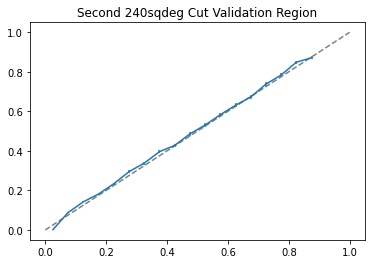

In [24]:
frac = N/M
print('frac = ', frac)
#fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
fracerr = (N/M)*np.sqrt((1/N.astype(float))-(1/M.astype(float)))

cut_err = []
for x in range(18):
    cut_err.append(fracerr[x])
#print("frac_err", fracerr)
#print("cut_err", cut_err)

cut_frac = []
for x in range(18):
    cut_frac.append(frac[x])

cut_pcenter = []
for x in range(18):
    cut_pcenter.append(pcenter[x])

x1=cut_frac
x2=cut_pcenter # want mean in prob. bin, not center
err=cut_err
chi2 = []
for x in range(18):
    a = (x1[x]-x2[x])**2
    b = err[x]**2
    chi2.append(a/b)
#chi2 = (x1-x2)**2 / err **2 

#mean diff of a, max limit of tolerance from these calc

chi2_reduced = sum(chi2)/len(chi2)
print("chi2_reduced: ",chi2_reduced)
print("size: ",len(chi2))
print("sum of chi2: ",sum(chi2))

print(chi2)

fig, ax = plt.subplots()
ax.errorbar( cut_pcenter, cut_frac, yerr=cut_err)
ax.plot([0,1], [0,1], ls='--', color='grey')
#ax.legend(chi2_reduced)
plt.title('Second 240sqdeg Cut Validation Region')
fig.savefig('DET_240Val2_err.pdf')

In [23]:
# save the samples. 
outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_st82_val_240new1.fits', dmass_st82_val2, overwrite=True)
esutil.io.write( outdir+'dmass_st82_val_240new2.fits', dmass_st82_val3, overwrite=True)
esutil.io.write( outdir+'dmass_st82_val_300old.fits', dmass_st82_val1, overwrite=True)

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00117577 0.08811354 0.14221671 0.18160985 0.23355784 0.29464286
 0.33790635 0.39575488 0.42746401 0.48571429 0.53038916 0.5827473
 0.63073852 0.67243133 0.73765432 0.78387909 0.84860558 0.87121212
 0.89798339 0.91739553]
chi2_reduced:  0.4843850578228454
size:  20
sum of chi2:  9.687701156456908


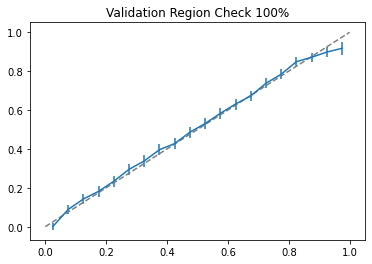

In [22]:
#(Validation 1) Figure 3

mag = ['MAG_DETMODEL', 'MAG_DETMODEL']
err = ['MAGERR_DETMODEL', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

mask4 =(gold_st82['RA']>18)&(gold_st82['RA']<43)
mask4 = mask4 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v4 = gold_st82[mask4]

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_v4['RA'], \
                                         gold_st82_v4['DEC'],2./3600, maxmatch=1)
cmass_mask4 = np.zeros(gold_st82_v4.size, dtype=bool)
cmass_mask4[mg2] = 1
clean_cmass_data_des_v4, nocmass_v4 = gold_st82_v4[cmass_mask4], gold_st82_v4[~cmass_mask4]

clean_dmass_prob4 = assignCMASSProb(clean_cmass_data_des_v4, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real4 = clean_dmass_prob4

dmass_st82_val4 = assignCMASSProb(gold_st82_v4, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real4['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val4['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
#fracerr = (N/M)*np.sqrt((1/N)-(1/M))

x1=frac
x2=pcenter
err=fracerr
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')
#ax.legend(chi2_reduced)
plt.title('Validation Region Check 100%')
fig.savefig('DET_Val_new_check.pdf')

#describe plot: ***used for model and validation sample-- what is done to create plot